# i. Data Preprocessing

## Imports

In [27]:
import datatable as dt
import pandas as pd
import csv
import numpy as np
from scipy import stats

from tqdm.notebook import tqdm
from IPython.display import clear_output
import time
from functools import wraps
from typing import (
    Optional,
    Tuple,
)
import re
from datetime import timedelta
from collections import Counter
import os
import warnings

warnings.filterwarnings(action='ignore')

## Load Dataset

1. Convert `.xlsx` to `.csv` on non fault OES data

### Preprocess Non Fault OES Data

In [2]:
dataset_path = 'dataset'

#### Try with one file

In [3]:
os.listdir(f'{dataset_path}/25um/OES Data')

['OES_25um_Fault_C4F8_90to85_SCCM.csv',
 'OES_25um_Fault_O2_13to11_SCCM.csv',
 'OES_25um_Fault_PlatenPower_17to15_Watt.CSV.csv',
 'OES_25um_Fault_SF6_130to122_SCCM.csv',
 'OES_25um_Fault_SourcePower_800to760_Watt.CSV.csv',
 'pickle',
 'S2514.xlsx',
 'S2515.xlsx',
 'S2516.xlsx',
 'S2517.xlsx',
 'S2518.xlsx',
 'S2519.xlsx',
 'S2520.xlsx',
 'S2521.xlsx',
 'S2522.xlsx',
 'S2523.xlsx',
 'S2524.xlsx',
 'S2525.xlsx']

In [4]:
%%time
filename = f'{dataset_path}/25um/OES Data/S2514.xlsx'
df = dt.fread(filename)

CPU times: total: 5min 25s
Wall time: 5min 28s


In [5]:
df = df.to_pandas()

1. get etch date

In [6]:
etch_date = (df
             .columns[1]
             .split('_')[0])

In [7]:
etch_date = re.sub(r'-', '', etch_date)

2. convert header to appropriate header

In [8]:
df.columns = df.iloc[1]

In [9]:
df = df.drop([0, 1]).reset_index(drop=True)

3. convert timestamp column and rename

In [10]:
df['Time(sec)'] = df['Time(sec)'].apply(lambda x: etch_date + re.sub(r'\D*', '', x))

In [11]:
df.rename({'Time(sec)': 'Time'}, axis=1, inplace=True)

4. add milliseconds

In [12]:
time_grp = df.iloc[:, :1].groupby('Time', group_keys=False)

In [13]:
_ = time_grp.get_group('20140209034837').reset_index(drop=True)

In [14]:
_['milliseconds'] = [str(x*100) for x in _.index]

In [15]:
pd.to_datetime(_.agg(''.join, axis=1), format=('%Y%m%d%H%M%S%f'))

0   2014-02-09 03:48:37.000
1   2014-02-09 03:48:37.100
2   2014-02-09 03:48:37.200
3   2014-02-09 03:48:37.300
4   2014-02-09 03:48:37.400
5   2014-02-09 03:48:37.500
6   2014-02-09 03:48:37.600
7   2014-02-09 03:48:37.700
8   2014-02-09 03:48:37.800
dtype: datetime64[ns]

In [17]:
%%time
new_date = {}
for k in time_grp.groups.keys():
    _ = time_grp.get_group(k).reset_index(drop=True)
    _['milliseconds'] = [str(x*100) for x in _.index]
    new_time_col = _.agg(''.join, axis=1)
    new_date[k] = pd.to_datetime(new_time_col, format=('%Y%m%d%H%M%S%f'))

CPU times: total: 1.02 s
Wall time: 1.02 s


In [18]:
new_date_col = pd.concat(new_date.values()).reset_index(drop=True)

In [19]:
df['Time'] = new_date_col

#### Apply to all data

`25um`, `80um`에 대해 모두 진행

##### Normal data

In [32]:
dir_list = [
    'dataset/80um/OES Data',
    'dataset/25um/OES Data',
]

for dir_ in dir_list:
    target_file = os.listdir(dir_)[6:]
    
    for i, filename in enumerate(target_file):
        try:
            clear_output(wait=True)
            print(f'[{i+1}/{len(target_file)}] >>> Processing "{filename}" ...')
            df = dt.fread(f'{dir_}/{filename}')
            df = df.to_pandas()

            etch_date = (df
                         .columns[1]
                         .split('_')[0])
            etch_date = re.sub(r'-', '', etch_date)

            df.columns = df.iloc[1]
            df = df.drop([0, 1]).reset_index(drop=True)
            df['Time(sec)'] = df['Time(sec)'].apply(lambda x: etch_date + re.sub(r'\D*', '', x))
            df.rename({'Time(sec)': 'Time'}, axis=1, inplace=True)

            time_grp = df.iloc[:, :1].groupby('Time', group_keys=False)
            new_date = {}
            for k in tqdm(time_grp.groups.keys()):
                _ = time_grp.get_group(k).reset_index(drop=True)
                _['milliseconds'] = [str(x*100) for x in _.index]
                new_time_col = _.agg(''.join, axis=1)
                new_date[k] = pd.to_datetime(new_time_col, format=('%Y%m%d%H%M%S%f'))

            new_date_col = pd.concat(new_date.values()).reset_index(drop=True)
            df['Time'] = new_date_col
            file = filename.split('.')[0]
            df.to_pickle(f'{dir_}/pickle/{file}.pkl')
        except Exception as e:
            print(e)
            print(f'>>> Error Location: {filename}')

[12/12] >>> Processing "S2525.xlsx" ...


##### Abnormal data

In [42]:
dir_list = [
    'dataset/80um/OES Data',
    'dataset/25um/OES Data',
]

for dir_ in dir_list:
    target_file = os.listdir(dir_)[:5]
    
    for i, filename in enumerate(target_file):
        try:
            clear_output(wait=True)
            print(f'[{i+1}/{len(target_file)}] >>> Processing "{filename}" ...')

            etch_date = ''
            df = []
            with open(f'{dir_}/{filename}', 'r', encoding='utf-8') as f:
                rdr = csv.reader(f)
                for i, line in enumerate(rdr):
                    if i == 0:
                        date_info = line[1]
                        etch_date = re.sub(r'-', '', date_info.split('_')[0])
                        continue
                    if i == 1:
                        continue
                    df.append(line)
            df = pd.DataFrame(df)
            df.columns = df.iloc[0, :]
            df.drop([0], inplace=True)
            df.drop([''], axis=1, inplace=True)
            df.reset_index(drop=True, inplace=True)

            df['Time(sec)'] = df['Time(sec)'].apply(lambda x: etch_date + re.sub(r'\D*', '', x))
            df.rename({'Time(sec)': 'Time'}, axis=1, inplace=True)
            time_grp = df.iloc[:, :1].groupby('Time', group_keys=False)

            new_date = {}
            for k in time_grp.groups.keys():
                _ = time_grp.get_group(k).reset_index(drop=True)
                _['milliseconds'] = [str(x*100) for x in _.index]
                new_time_col = _.agg(''.join, axis=1)
                new_date[k] = pd.to_datetime(new_time_col, format=('%Y%m%d%H%M%S%f'))

            new_date_col = pd.concat(new_date.values()).reset_index(drop=True)
            df['Time'] = new_date_col
            file = filename.split('.')[0]
            df.to_pickle(f'{dir_}/pickle/{file}.pkl')
        except Exception as e:
            print(e)
            print(f'>>> Error Location: {filename}')

[5/5] >>> Processing "OES_25um_Fault_SourcePower_800to760_Watt.CSV.csv" ...


##### Revert

시간에 대한 정보가 굳이 필요없어보임

In [ ]:
%%time
for micro_dir in ['25', '80']:
    dir_ = f'dataset//{micro_dir}um/OES Data/pickle'
    target_file = os.listdir(dir_)
    for i, filename in enumerate(target_file):
        try:
            print(f'[{i+1}/{len(target_file)}] >>> Processing "{filename}" ...')
            oes = pd.read_pickle(f'{dir_}/{filename}')
            oes.columns = oes.columns.astype(str)
            oes['Time'] = oes['Time'].values.astype('<M8[s]')
            oes['Time'] = oes['Time'].apply(lambda x: x.time().strftime(format='%Hh%Mm%Ss'))
            oes.rename({'Time': 'Time(sec)'}, axis=1, inplace=True)
            file = filename.split('.')[0]
            oes.to_pickle(f'{dir_}/{file}.pkl')
        except Exception as e:
            print(e)

### Preprocess FDC Data

#### Try with one file

In [66]:
df = load_dataset('dataset\\80um\FDC Data\FDC_80um_Fault_C4F8_90to85_SCCM.csv')

>>> load_dataset('dataset\\80um\\FDC Data\\FDC_80um_Fault_C4F8_90to85_SCCM.csv',) => (0.01s)


날짜 형식이 안맞아서 14-02-08이 2008-2-14로 나옴

In [67]:
date = df.iloc[1, 2]
time_ = df.iloc[2, 2]
date = pd.to_datetime(date, dayfirst=True).strftime(format='%Y-%m-%d')
date_time = ' '.join([date, time_])

In [68]:
date_time

'2014-02-08 22:55:49'

In [72]:
df.columns = df.iloc[6]

In [ ]:
df = df.iloc[7:, :]

In [78]:
df['date'] = date_time

In [79]:
df.insert(
    0,
    'date',
    df.pop('date')
)

In [81]:
df.head(3)

6,date,Time,[1] C4F8,[2] SF6,[3] O2,Pressure,RF1 Power,RF1 Reflected,RF Peak,RF Bias,...,RF2 Load,RF2 Tune,APC Angle,He Leakup Rate,He Pressure,He Flow,Process Phase,ASE Phase,ASE Cycles,ASE Downcount
7,2014-02-08 22:55:49,0,0,0,0,0,0.5,0.1,0,0,...,49.2,49.9,66,0,2.6,2.8,PumpingToTripPressure,,,
8,2014-02-08 22:55:49,0,0,0,0,0,0.5,0.1,0,0,...,35.6,45.1,68.4,2.1,1.3,2.8,GasStab,,,
9,2014-02-08 22:55:49,63,46.4,35.4,0,100,0.5,0.1,0,3,...,35.5,45.1,18.8,2.1,1.3,3.2,GasStab,,,


#### Apply to all data

In [44]:
dir_list = [
    'dataset/80um/FDC Data',
    'dataset/25um/FDC Data',
]
for dir_ in dir_list:
    target_file = os.listdir(dir_)
    
    for i, filename in enumerate(target_file):
        try:
            clear_output(wait=True)
            print(f'[{i+1}/{len(target_file)}] >>> Processing "{filename}" ...')
            file = filename.split('.')
            if (file == '') or (len(file) == 1):
                print(f'Skipping file "{filename}". Not a csv file.')
                continue

            df = load_dataset(f'{dir_}/{filename}')
            date = df.iloc[1, 2]
            time_ = df.iloc[2, 2]
            date = pd.to_datetime(date, dayfirst=True).strftime(format='%Y-%m-%d')
            date_time = ' '.join([date, time_])
            df.columns = df.iloc[6]
            df = df.iloc[7:, :]
            df['date'] = date_time
            df.insert(
                0,
                'date',
                df.pop('date')
            )
            file = file[0]
            df.to_pickle(f'{dir_}/pickle/{file}.pkl')
        except Exception as e:
            print(e)
            print(f'>>> Error Location: {filename}')

[19/19] >>> Processing "pickle" ...


# ii. Feature Selection in OES Data

## Imports

In [1]:
from tqdm.notebook import tqdm
import os
import re
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings(action='ignore')

## Try with one wafer

## Load Dataset

In [4]:
micro_dir = '80'

In [5]:
dir_ = f'dataset//{micro_dir}um/OES Data/pickle'
file_list = os.listdir(dir_)
file_list

['1d_oes_data',
 'feature_reduced',
 'OES_80um_Fault_C4F8_90to85_SCCM.pkl',
 'OES_80um_Fault_O2_13to11_SCCM.pkl',
 'OES_80um_Fault_PlatenPower_17to15_Watt.pkl',
 'OES_80um_Fault_SF6_130to122_SCCM.pkl',
 'OES_80um_Fault_SourcePower_800to760_Watt.pkl',
 'S8014.pkl',
 'S8015.pkl',
 'S8016.pkl',
 'S8017.pkl',
 'S8018.pkl',
 'S8019.pkl',
 'S8020.pkl',
 'S8021.pkl',
 'S8022.pkl',
 'S8023.pkl',
 'S8024.pkl',
 'S8025.pkl',
 'timeseries_summary']

In [8]:
oes = pd.read_pickle(f'{dir_}/S{micro_dir}14.pkl')
oes = oes.set_index('Time(sec)').astype(float).reset_index()

## Variable Selection

PCA가 분산이 큰 방향으로 주성분을 생성한다는 성질을 이용하여 분산이 큰 파장을 임의의 기준으로 선택

#### Get threshold

In [9]:
oes_wavelength_std = oes.std()

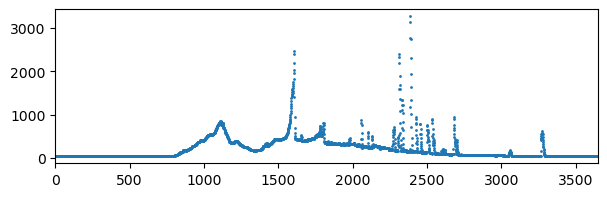

In [10]:
plt.figure(figsize=(7, 2))
plt.scatter(x=range(len(oes_wavelength_std)), y=oes_wavelength_std, s=1)
plt.margins(x=0)
plt.show()

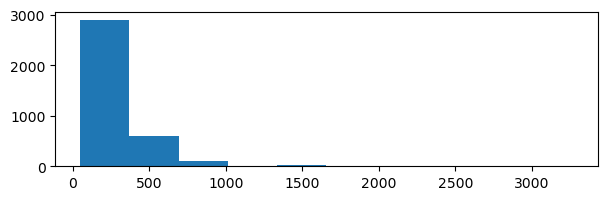

In [11]:
plt.figure(figsize=(7, 2))
n, bins, _ = plt.hist(oes_wavelength_std)
plt.show()

In [21]:
percentile = 70
n, bins = np.histogram(oes_wavelength_std)
threshold = np.percentile(bins, percentile)
top_oes_std = oes_wavelength_std[oes_wavelength_std.sort_values(ascending=False) > threshold]

In [22]:
threshold

2302.582711222567

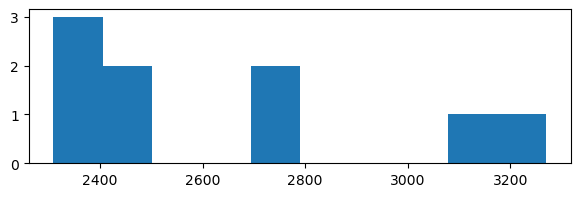

In [23]:
plt.figure(figsize=(7, 2))
plt.hist(top_oes_std)
plt.show()

#### Select variables

In [24]:
wavelength_set = [wavelength.split('.')[0] for wavelength in top_oes_std.index]
wavelength_set = set(wavelength_set)
wavelength_set = sorted(wavelength_set)

In [25]:
oes_wavelength_container = {}
for i in wavelength_set:
    pattern = f'^{i}'
    oes_wavelength_container[i] = oes.filter(regex=pattern, axis=1)

In [26]:
oes_wavelength_container = pd.concat(oes_wavelength_container.values(), axis=1)

표준편차가 가장 큰 파장

In [27]:
oes_wavelength_std.to_frame().T[oes_wavelength_container.columns].iloc[0]

1
517.126    2410.138744
517.36     2471.753322
517.595    2040.716235
517.83     1402.994157
686.106    1586.638107
686.349    2333.745919
686.592    2398.772352
686.836    2187.295356
704.138    1189.078737
704.382    2771.903566
704.626    3270.189768
704.87     3134.001354
705.114    2750.770136
705.358    2308.830534
705.602    1945.293091
705.846    1649.551160
Name: 0, dtype: float64

In [28]:
wavelength_candidate = oes_wavelength_std.to_frame().T[oes_wavelength_container.columns].iloc[0]
highest_std_wavelength = wavelength_candidate[wavelength_candidate > threshold]
highest_std_wavelength_container = {}
for i in highest_std_wavelength.index:
    pattern = f'^{i}'
    highest_std_wavelength_container[i] = oes.filter(regex=pattern, axis=1)
highest_std_wavelength_container = pd.concat(highest_std_wavelength_container.values(), axis=1)

reduced_wavelength = pd.concat([
    oes['Time(sec)'],
    highest_std_wavelength_container,
], axis=1)

In [29]:
reduced_wavelength

,Time(sec),517.126,517.36,686.349,686.592,704.382,704.626,704.87,705.114,705.358
0,21h15m07s,2854.0,2848.0,2732.0,2790.0,2829.0,2780.0,2801.0,2843.0,2784.0
1,21h15m07s,2854.0,2848.0,2732.0,2790.0,2829.0,2780.0,2801.0,2843.0,2784.0
2,21h15m07s,2802.0,2850.0,2904.0,2883.0,2955.0,2856.0,2774.0,2771.0,2766.0
3,21h15m07s,2862.0,2897.0,2889.0,2845.0,2792.0,2787.0,2873.0,2841.0,2800.0
4,21h15m07s,2779.0,2757.0,2845.0,2914.0,2893.0,2862.0,2816.0,2741.0,2721.0
...,...,...,...,...,...,...,...,...,...,...
8813,21h31m09s,2787.0,2772.0,2809.0,2776.0,2826.0,2772.0,2792.0,2783.0,2767.0
8814,21h31m10s,2860.0,2852.0,2820.0,2845.0,2860.0,2846.0,2783.0,2797.0,2801.0
8815,21h31m10s,2873.0,2879.0,2772.0,2842.0,2849.0,2872.0,2837.0,2866.0,2828.0
8816,21h31m10s,2891.0,2890.0,2848.0,2774.0,2853.0,2785.0,2788.0,2745.0,2756.0


## Apply to All

In [45]:
def feature_selection(path: str, percentile_threshold: int) -> None:
    file_list = os.listdir(path)
    
    for i, filename in enumerate(file_list):
        try:
            print(f'[{i+1}/{len(file_list)}] >>> Processing "{filename}" ...')
            file = filename.split('.')
            if (file == '') or (len(file) == 1):
                print(f'Skipping file "{filename}". Not a pickle file.')
                continue

            oes = pd.read_pickle(f'{path}/{filename}')
            oes = (oes
                   .set_index('Time(sec)')
                   .astype(float)
                   .reset_index())
            oes = oes.dropna(how='all')
            oes_wavelength_std = oes.std()

            n, bins = np.histogram(oes_wavelength_std)
            threshold = np.percentile(bins, percentile_threshold)
            top_oes_std = oes_wavelength_std[
                oes_wavelength_std.sort_values(ascending=False) > threshold
            ]
            wavelength_set = [
                wavelength.split('.')[0]
                for wavelength
                in top_oes_std.index
            ]
            wavelength_set = set(wavelength_set)
            wavelength_set = sorted(wavelength_set)
            
            oes_wavelength_container = {}

            for i in wavelength_set:
                pattern = f'^{i}'
                oes_wavelength_container[i] = oes.filter(regex=pattern, axis=1)
                
            oes_wavelength_container = pd.concat(oes_wavelength_container.values(),
                                                 axis=1)
            wavelength_candidate = oes_wavelength_std.to_frame().T[oes_wavelength_container.columns].iloc[0]
            highest_std_wavelength = wavelength_candidate[wavelength_candidate > threshold]
            highest_std_wavelength_container = {}
            
            for i in highest_std_wavelength.index:
                pattern = f'^{i}'
                highest_std_wavelength_container[i] = oes.filter(regex=pattern, axis=1)
                
            highest_std_wavelength_container = pd.concat(highest_std_wavelength_container.values(), axis=1)
            reduced_wavelength = pd.concat([
                oes['Time(sec)'],
                highest_std_wavelength_container,
            ], axis=1)
            reduced_wavelength.to_pickle(f'{path}/feature_reduced/{filename}')
        except Exception as e:
             print(e)

### 25um

25um은 threshold가 80 백분위수의 값으로 설정

In [2]:
%%time
dir_ = f'dataset//25um/OES Data/pickle'
feature_selection(path=dir_, percentile_threshold=80)

[1/20] >>> Processing "1d_oes_data" ...
Skipping file "1d_oes_data". Not a pickle file.
[2/20] >>> Processing "feature_reduced" ...
Skipping file "feature_reduced". Not a pickle file.
[3/20] >>> Processing "OES_25um_Fault_C4F8_90to85_SCCM.pkl" ...
[4/20] >>> Processing "OES_25um_Fault_O2_13to11_SCCM.pkl" ...
[5/20] >>> Processing "OES_25um_Fault_PlatenPower_17to15_Watt.pkl" ...
[6/20] >>> Processing "OES_25um_Fault_SF6_130to122_SCCM.pkl" ...
[7/20] >>> Processing "OES_25um_Fault_SourcePower_800to760_Watt.pkl" ...
[8/20] >>> Processing "S2514.pkl" ...
[9/20] >>> Processing "S2515.pkl" ...
[10/20] >>> Processing "S2516.pkl" ...
[11/20] >>> Processing "S2517.pkl" ...
[12/20] >>> Processing "S2518.pkl" ...
[13/20] >>> Processing "S2519.pkl" ...
[14/20] >>> Processing "S2520.pkl" ...
[15/20] >>> Processing "S2521.pkl" ...
[16/20] >>> Processing "S2522.pkl" ...
[17/20] >>> Processing "S2523.pkl" ...
[18/20] >>> Processing "S2524.pkl" ...
[19/20] >>> Processing "S2525.pkl" ...
[20/20] >>> Pro

### 80um

80um은 threshold가 60 백분위수의 값으로 설정

In [34]:
%%time
dir_ = f'dataset//80um/OES Data/pickle'
feature_selection(path=dir_, percentile_threshold=60)

[1/20] >>> Processing "1d_oes_data" ...
Skipping file "1d_oes_data". Not a pickle file.
[2/20] >>> Processing "feature_reduced" ...
Skipping file "feature_reduced". Not a pickle file.
[3/20] >>> Processing "OES_80um_Fault_C4F8_90to85_SCCM.pkl" ...
[4/20] >>> Processing "OES_80um_Fault_O2_13to11_SCCM.pkl" ...
[5/20] >>> Processing "OES_80um_Fault_PlatenPower_17to15_Watt.pkl" ...
[6/20] >>> Processing "OES_80um_Fault_SF6_130to122_SCCM.pkl" ...
[7/20] >>> Processing "OES_80um_Fault_SourcePower_800to760_Watt.pkl" ...
[8/20] >>> Processing "S8014.pkl" ...
[9/20] >>> Processing "S8015.pkl" ...
[10/20] >>> Processing "S8016.pkl" ...
[11/20] >>> Processing "S8017.pkl" ...
[12/20] >>> Processing "S8018.pkl" ...
[13/20] >>> Processing "S8019.pkl" ...
[14/20] >>> Processing "S8020.pkl" ...
[15/20] >>> Processing "S8021.pkl" ...
[16/20] >>> Processing "S8022.pkl" ...
[17/20] >>> Processing "S8023.pkl" ...
[18/20] >>> Processing "S8024.pkl" ...
[19/20] >>> Processing "S8025.pkl" ...
[20/20] >>> Pro

# iii. Summary OES Time Series Data

## Imports

In [1]:
from tqdm.notebook import tqdm
import os
import re
import pandas as pd
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7, 2)
warnings.filterwarnings(action='ignore')

## Try with one wafer

### Load Dataset

In [43]:
micro_dir = '25'
dir_ = f'dataset//{micro_dir}um/OES Data/pickle/feature_reduced'
file_list = os.listdir(dir_)
oes = pd.read_pickle(f'{dir_}/{file_list[0]}')

In [44]:
file_list

['OES_25um_Fault_C4F8_90to85_SCCM.pkl',
 'OES_25um_Fault_O2_13to11_SCCM.pkl',
 'OES_25um_Fault_PlatenPower_17to15_Watt.pkl',
 'OES_25um_Fault_SF6_130to122_SCCM.pkl',
 'OES_25um_Fault_SourcePower_800to760_Watt.pkl',
 'S2514.pkl',
 'S2515.pkl',
 'S2516.pkl',
 'S2517.pkl',
 'S2518.pkl',
 'S2519.pkl',
 'S2520.pkl',
 'S2521.pkl',
 'S2522.pkl',
 'S2523.pkl',
 'S2524.pkl',
 'S2525.pkl',
 'timeseries_summary']

In [9]:
oes = oes.set_index('Time(sec)')

In [203]:
oes

,Time(sec),516.186,516.421,516.656,516.891,517.126,517.36,517.595,517.83,686.106,...,687.566,687.809,704.138,704.382,704.626,704.87,705.114,705.358,705.602,705.846
0,21h34m13s,2908.0,2881.0,2861.0,2750.0,2812.0,2818.0,2811.0,2869.0,2805.0,...,2817.0,2873.0,2893.0,2869.0,2806.0,2830.0,2817.0,2743.0,2731.0,2802.0
1,21h34m13s,4835.0,4885.0,5069.0,5184.0,5495.0,5525.0,5120.0,4454.0,3128.0,...,3130.0,3134.0,3072.0,3317.0,3362.0,3413.0,3332.0,3203.0,3163.0,3204.0
2,21h34m13s,4835.0,4885.0,5069.0,5184.0,5495.0,5525.0,5120.0,4454.0,3128.0,...,3130.0,3134.0,3072.0,3317.0,3362.0,3413.0,3332.0,3203.0,3163.0,3204.0
3,21h34m13s,3902.0,3879.0,3916.0,3925.0,3952.0,3937.0,3878.0,3636.0,3131.0,...,3210.0,3264.0,3087.0,3181.0,3204.0,3247.0,3197.0,3115.0,3158.0,3280.0
4,21h34m13s,3106.0,3175.0,3210.0,3137.0,3113.0,3067.0,3116.0,3118.0,2972.0,...,3074.0,3019.0,3005.0,3071.0,3036.0,2949.0,2934.0,2951.0,2941.0,3023.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,21h50m10s,2962.0,2937.0,2953.0,2931.0,2856.0,2875.0,2897.0,2857.0,2857.0,...,2875.0,2872.0,2889.0,2870.0,2821.0,2782.0,2820.0,2847.0,2811.0,2891.0
8756,21h50m10s,2926.0,2903.0,2893.0,2860.0,2846.0,2838.0,2864.0,2837.0,2855.0,...,2928.0,2968.0,2944.0,2903.0,2889.0,2868.0,2831.0,2868.0,2846.0,2881.0
8757,21h50m10s,2880.0,2916.0,2896.0,2890.0,2908.0,2817.0,2812.0,2842.0,2855.0,...,2838.0,2897.0,2875.0,2855.0,2870.0,2891.0,2868.0,2877.0,2856.0,2867.0
8758,21h50m10s,2857.0,2909.0,2933.0,2857.0,2825.0,2765.0,2770.0,2748.0,2883.0,...,2839.0,2921.0,2871.0,2897.0,2867.0,2932.0,2968.0,2932.0,2852.0,2849.0


### Plot Wavelengths

표준편차가 큰 wavelength들의 모양을 함 보자

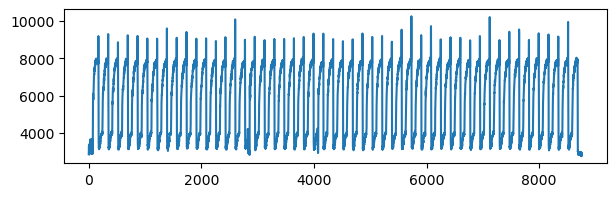

In [13]:
plt.plot(range(len(oes)), oes.iloc[:, 10])
plt.show()

그럼 표준편차 기준으로 drop된 wavelength들의 모양을 확인해보자

In [14]:
df = pd.read_pickle('dataset//25um/OES Data/pickle/S2514.pkl')
df.shape

(8716, 3649)

In [15]:
df = df.set_index('Time(sec)')

In [16]:
df = df.astype(float)

In [17]:
df = df.reset_index()

In [18]:
df = df.groupby('Time(sec)').agg(np.mean)

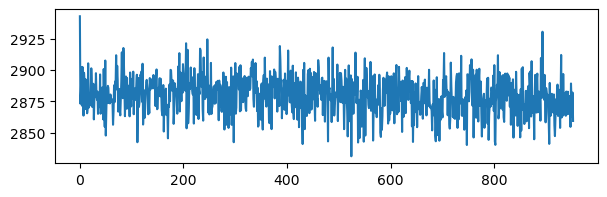

In [19]:
wavelength = '162.969'
plt.plot(range(len(df)), df[wavelength])
plt.show()

선택은 안됐지만 표준편차가 튄 wavelength 확인

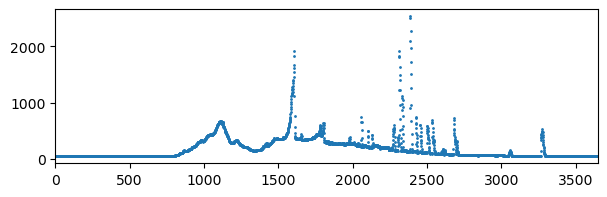

In [139]:
# wavelength들의 표준편차 plot

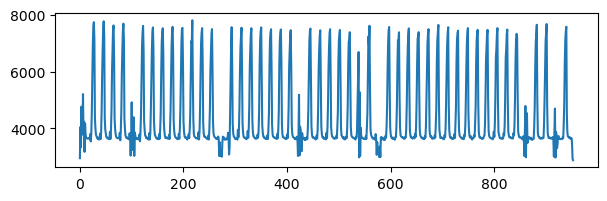

In [20]:
place = 1600
plt.plot(range(len(df)), df.iloc[:, place])
plt.show()

### Summary Data

oes wavelength를 정보손실을 최소화하면서 summary 값으로 만들어주어야할 듯

>  Most of the existing models select specific summary values for each predictor over a given time period and concatenate them to form patient vectors. Statistics are a form of summary values, and studies have shown that summary statistics can reflect the characteristics of time series. Moreover, they have advantages such as simple extraction, high robustness and strong representativeness [8–10]. The features of time series can be divided into three aspects: central tendency, dispersion tendency and distribution shape. The distribution and trends of time series can be reflected by combining multiple summary statistics, thus approximating the original data distribution and reducing the impact of noise on the prediction results.
> 
> *Guo, C., Lu, M. & Chen, J. An evaluation of time series summary statistics as features for clinical prediction tasks. BMC Med Inform Decis Mak 20, 48 (2020). https://doi.org/10.1186/s12911-020-1063-x*

## Apply to all data

In [70]:
%%time
for micro_dir in ['25', '80']:
    dir_ = f'dataset//{micro_dir}um/OES Data/pickle'
    file_list = os.listdir(dir_)
    
    for i, filename in enumerate(file_list):
        try:
            print(f'[{i+1}/{len(file_list)}] >>> Processing "{filename}" ...')
            file = filename.split('.')
            if (file == '') or (len(file) == 1):
                print(f'Skipping file "{filename}". Not a pickle file.')
                continue

            oes = pd.read_pickle(f'{dir_}/feature_reduced/{filename}')
            oes = oes.set_index('Time(sec)')
            oes = oes.dropna(how='all')
            oes = oes.astype(float)
            oes_summary = {}
            
            for x in oes.columns:  # 통계량 선택
                statistic_container = {}
                statistic_container['mean'] = oes[x].mean()
                statistic_container['min'] = oes[x].min()
                statistic_container['max'] = oes[x].max()
                oes_summary[x] = pd.Series(statistic_container, name=x)
            oes_summary = pd.concat(oes_summary.values(), axis=1)
            oes_summary.to_pickle(f'{dir_}/timeseries_summary/{file[0]}.pkl')
        except Exception as e:
            raise

[1/20] >>> Processing "1d_oes_data" ...
Skipping file "1d_oes_data". Not a pickle file.
[2/20] >>> Processing "feature_reduced" ...
Skipping file "feature_reduced". Not a pickle file.
[3/20] >>> Processing "OES_25um_Fault_C4F8_90to85_SCCM.pkl" ...
[4/20] >>> Processing "OES_25um_Fault_O2_13to11_SCCM.pkl" ...
[5/20] >>> Processing "OES_25um_Fault_PlatenPower_17to15_Watt.pkl" ...
[6/20] >>> Processing "OES_25um_Fault_SF6_130to122_SCCM.pkl" ...
[7/20] >>> Processing "OES_25um_Fault_SourcePower_800to760_Watt.pkl" ...
[8/20] >>> Processing "S2514.pkl" ...
[9/20] >>> Processing "S2515.pkl" ...
[10/20] >>> Processing "S2516.pkl" ...
[11/20] >>> Processing "S2517.pkl" ...
[12/20] >>> Processing "S2518.pkl" ...
[13/20] >>> Processing "S2519.pkl" ...
[14/20] >>> Processing "S2520.pkl" ...
[15/20] >>> Processing "S2521.pkl" ...
[16/20] >>> Processing "S2522.pkl" ...
[17/20] >>> Processing "S2523.pkl" ...
[18/20] >>> Processing "S2524.pkl" ...
[19/20] >>> Processing "S2525.pkl" ...
[20/20] >>> Pro

# iv. Unfold OES Data

OES 데이터를 2차원으로 unfolding

## Imports

In [1]:
from tqdm.notebook import tqdm
import os
import re
import pandas as pd
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7, 2)
warnings.filterwarnings(action='ignore')

## Unfold

### Try with one wafer

In [ ]:
flatten_values = oes.T.to_numpy().flatten()
new_col = []
for col in oes.columns:
    for statistic in oes.index:
        new_col.append(f'{col}_{statistic}')
wafer[file[0]] = pd.Series(flatten_values, index=new_col, name=file[0])
merged = (pd.concat(wafer.values(), axis=1)
          .T
          .dropna(axis=1)
          .reset_index()
          .rename({'index': 'wafer'}, axis=1))

### Apply to all data

In [70]:
for micro_dir in ['25', '80']:
    dir_ = f'dataset//{micro_dir}um/OES Data/pickle'
    file_list = os.listdir(dir_)
    wafer = {}
    for i, filename in enumerate(file_list):
        try:
            print(f'[{i+1}/{len(file_list)}] >>> Processing "{filename}" ...')
            file = filename.split('.')
            if (file == '') or (len(file) == 1):
                print(f'Skipping file "{filename}". Not a pickle file.')
                continue

            oes = pd.read_pickle(f'{dir_}/timeseries_summary/{filename}')
            flatten_values = oes.T.to_numpy().flatten()
            new_col = []
            for col in oes.columns:
                for statistic in oes.index:
                    new_col.append(f'{col}_{statistic}')
            wafer[file[0]] = pd.Series(flatten_values, index=new_col, name=file[0])
        except Exception as e:
            raise
    merged = (pd.concat(wafer.values(), axis=1)
              .T
              .dropna(axis=1)
              .reset_index()
              .rename({'index': 'wafer'}, axis=1))
    merged.to_pickle(f'{dir_}//1d_oes_data/final_oes_data.pkl')

[1/20] >>> Processing "1d_oes_data" ...
Skipping file "1d_oes_data". Not a pickle file.
[2/20] >>> Processing "feature_reduced" ...
Skipping file "feature_reduced". Not a pickle file.
[3/20] >>> Processing "OES_25um_Fault_C4F8_90to85_SCCM.pkl" ...
[4/20] >>> Processing "OES_25um_Fault_O2_13to11_SCCM.pkl" ...
[5/20] >>> Processing "OES_25um_Fault_PlatenPower_17to15_Watt.pkl" ...
[6/20] >>> Processing "OES_25um_Fault_SF6_130to122_SCCM.pkl" ...
[7/20] >>> Processing "OES_25um_Fault_SourcePower_800to760_Watt.pkl" ...
[8/20] >>> Processing "S2514.pkl" ...
[9/20] >>> Processing "S2515.pkl" ...
[10/20] >>> Processing "S2516.pkl" ...
[11/20] >>> Processing "S2517.pkl" ...
[12/20] >>> Processing "S2518.pkl" ...
[13/20] >>> Processing "S2519.pkl" ...
[14/20] >>> Processing "S2520.pkl" ...
[15/20] >>> Processing "S2521.pkl" ...
[16/20] >>> Processing "S2522.pkl" ...
[17/20] >>> Processing "S2523.pkl" ...
[18/20] >>> Processing "S2524.pkl" ...
[19/20] >>> Processing "S2525.pkl" ...
[20/20] >>> Pro

## Plot Selected Wavelengths

In [71]:
micro_dir = '25'
dir_ = f'dataset//{micro_dir}um/OES Data/pickle'
merged = pd.read_pickle(f'{dir_}//1d_oes_data/final_oes_data.pkl')

In [75]:
mean_df = merged.filter(like='mean', axis=1)
mean_df = pd.concat([
    merged['wafer'],
    mean_df,
], axis=1)

single positional indexer is out-of-bounds


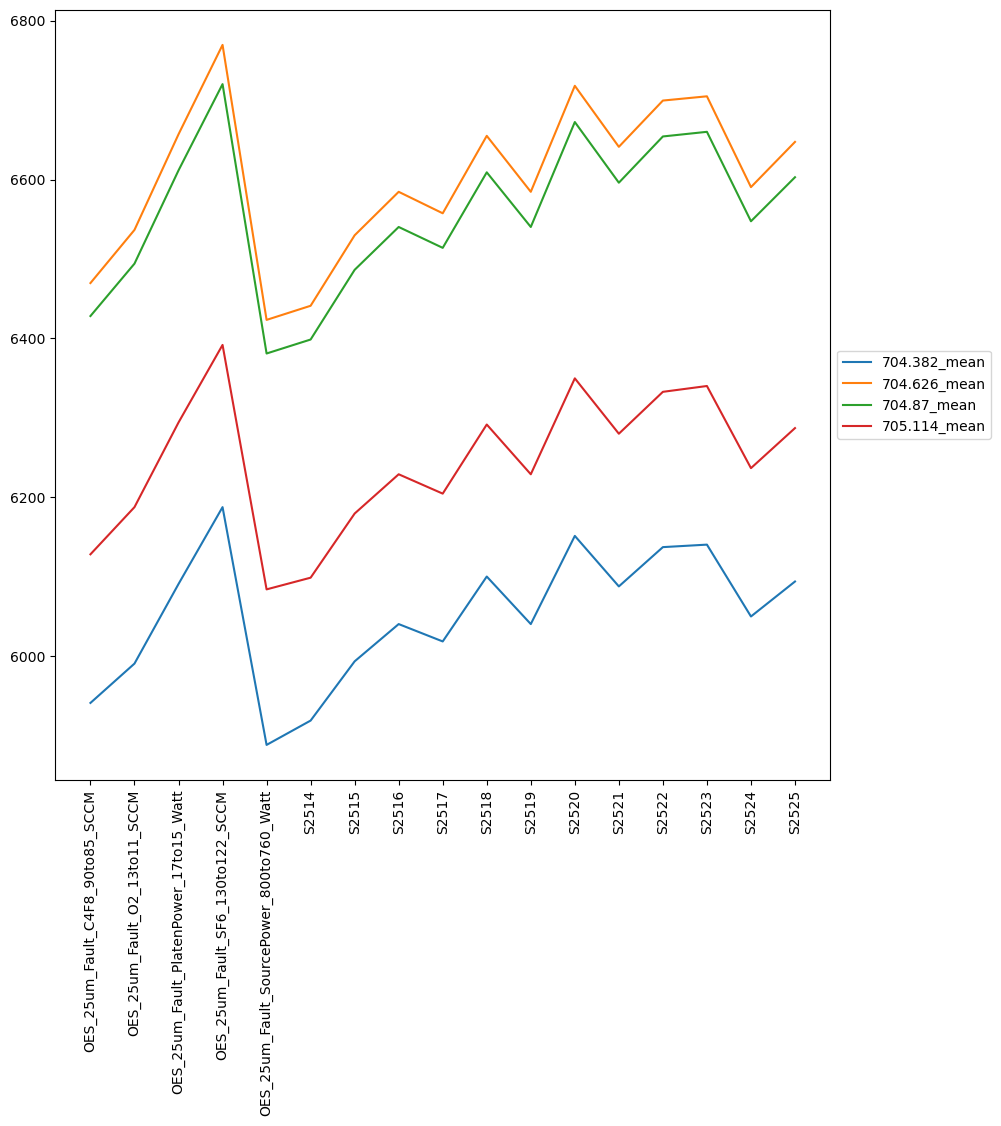

In [76]:
plt.figure(figsize=(10, 10))
for i, v in enumerate(mean_df):
    try:
        plt.plot(mean_df.iloc[:, 0], mean_df.iloc[:, i+1], label=mean_df.iloc[:, i+1].name)
    except Exception as e:
        print(e)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.show()

# v. Unfold FDC Data

FDC 데이터를 passivation, etch 로 컬럼을 구성하기

## Imports

In [1]:
from tqdm.notebook import tqdm
import os
import re
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings(action='ignore')

## Try with one wafer

### Load Dataset

In [130]:
micro_dir = '80'
dir_ = f'dataset//{micro_dir}um/FDC Data/pickle'
file_list = os.listdir(dir_)
file_list

['.ipynb_checkpoints',
 '1d_fdc_data',
 'FDC_80um_Fault_C4F8_90to85_SCCM.pkl',
 'FDC_80um_Fault_O2_13to11_SCCM.pkl',
 'FDC_80um_Fault_PlatenPower_17to15_Watt.pkl',
 'FDC_80um_Fault_SF6_130to122_SCCM.pkl',
 'FDC_80um_Fault_SourcePower_800to760_Watt.pkl',
 'FDC_TSV80_ (14).pkl',
 'FDC_TSV80_ (15).pkl',
 'FDC_TSV80_ (16).pkl',
 'FDC_TSV80_ (17).pkl',
 'FDC_TSV80_ (18).pkl',
 'FDC_TSV80_ (19).pkl',
 'FDC_TSV80_ (20).pkl',
 'FDC_TSV80_ (21).pkl',
 'FDC_TSV80_ (22).pkl',
 'FDC_TSV80_ (23).pkl',
 'FDC_TSV80_ (24).pkl',
 'FDC_TSV80_ (25).pkl']

In [133]:
fdc = pd.read_pickle(f'{dir_}/FDC_TSV80_ (16).pkl')
fdc.shape

(968, 23)

In [134]:
fdc.columns.name = None

#### `ASE Downcount`가 시작되는 row만 추출

In [135]:
fdc = fdc.reset_index(drop=True)

In [136]:
fdc.head(20)

,Time,[1] C4F8,[2] SF6,[3] O2,Pressure,RF1 Power,RF1 Reflected,RF Peak,RF Bias,RF1 Load,...,RF2 Load,RF2 Tune,APC Angle,He Leakup Rate,He Pressure,He Flow,Process Phase,ASE Phase,ASE Cycles,ASE Downcount
0,0.0,0.0,0.0,0.0,0.0,0.5,0.1,0.0,0.0,49.1,...,49.2,49.9,0.0,0.0,1.9,2.8,PumpingToTripPressure,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.5,0.1,0.0,0.0,49.3,...,35.6,45.1,24.0,7.4,1.3,2.8,GasStab,NaN,NaN,NaN
2,63.0,86.0,306.9,0.6,100.0,0.5,0.1,0.0,0.0,49.3,...,35.6,45.0,24.0,7.4,1.3,3.3,GasStab,NaN,NaN,NaN
3,64.0,89.2,14.4,0.6,100.0,0.5,0.1,0.0,0.0,49.1,...,35.5,45.0,66.0,7.4,2.0,7.4,GasStab,NaN,NaN,NaN
4,65.0,89.8,0.6,0.4,6.0,0.5,0.1,0.0,0.0,49.1,...,35.4,45.0,68.4,7.4,3.3,9.9,GasStab,NaN,NaN,NaN
5,66.0,90.0,0.0,0.3,6.3,0.5,0.1,0.0,1.5,49.2,...,35.5,45.0,68.4,7.4,4.7,12.4,GasStab,NaN,NaN,NaN
6,67.0,90.0,0.0,0.3,6.3,0.5,0.1,0.0,0.0,49.1,...,35.5,45.0,68.4,7.4,5.9,14.9,GasStab,NaN,NaN,NaN
7,68.0,90.0,0.0,0.2,6.3,0.5,0.1,0.0,0.0,49.2,...,35.5,44.9,68.4,7.4,7.0,17.3,GasStab,NaN,NaN,NaN
8,69.0,90.2,0.0,0.2,6.3,0.5,0.1,10.0,0.0,49.1,...,35.4,44.9,68.4,7.4,5.2,19.7,GasStab,NaN,NaN,NaN
9,70.0,90.0,0.0,0.2,6.3,0.5,0.1,0.0,0.0,49.1,...,35.4,44.9,68.4,7.4,6.5,22.2,GasStab,NaN,NaN,NaN


In [137]:
fdc_process = fdc[fdc['Process Phase'] == 'Process']

In [138]:
fdc_process = fdc_process.where(fdc_process != '')
fdc_process.isna().sum().sum()

3

In [139]:
fdc_process[fdc_process.isna().any(axis=1)]

,Time,[1] C4F8,[2] SF6,[3] O2,Pressure,RF1 Power,RF1 Reflected,RF Peak,RF Bias,RF1 Load,...,RF2 Load,RF2 Tune,APC Angle,He Leakup Rate,He Pressure,He Flow,Process Phase,ASE Phase,ASE Cycles,ASE Downcount
11,72.0,90.2,0.0,0.2,6.3,0.5,0.1,0.0,0.0,49.1,...,35.4,44.9,68.4,7.4,9.1,27.0,Process,NaN,NaN,0.0
12,73.0,90.0,0.0,0.2,6.4,0.5,0.1,20.0,0.0,49.1,...,35.4,45.8,68.4,7.4,10.0,27.8,Process,NaN,50.0,0.0


In [140]:
fdc_process.dropna(inplace=True)

In [141]:
for col in fdc_process:
    if (col == 'Time') or (col == 'ASE Cycles') or (col == 'ASE Downcount'):
        fdc_process.loc[:, col] = (fdc_process[col]
                                   .astype(int)
                                   .astype(str))
    else:
        try:
            fdc_process.loc[:, col] = fdc_process[col].astype(float)
        except (AttributeError, ValueError):
            fdc_process.loc[:, col] = fdc_process[col].astype(str)

### Plot Gas

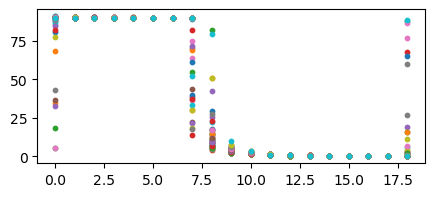

In [142]:
plt.figure(figsize=(5, 2))
gas = '[1] C4F8'
# gas = '[2] SF6'
# gas = '[3] O2'
for i in range(1, 51):
    plt.scatter(
        x=range(len(fdc_process.groupby('ASE Cycles').get_group(str(i))[gas])),
        y=fdc_process.groupby('ASE Cycles').get_group(str(i))[gas],
        s=10,
    )
plt.show()

gas의 주입량은 Passivation과 Etch 때 모두 동일함

단 gas가 주입되고 끊기는 시점이 완벽하게 Pass, Etch 구간으로 떨어지진 않음

값의 변동이 거의 없는 변수들을 제거

In [143]:
fdc_process_std = fdc_process.std()

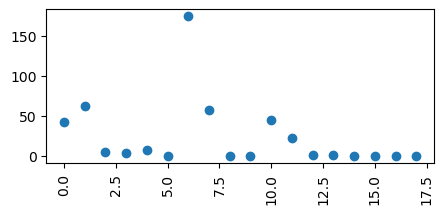

In [144]:
plt.figure(figsize=(5, 2))
plt.scatter(range(len(fdc_process_std)), fdc_process_std)
plt.xticks(rotation=90)
plt.show()

In [145]:
fdc_process_std.sort_values(ascending=False) > 0.5

RF Peak            True
[2] SF6            True
RF Bias            True
RF2 Power          True
[1] C4F8           True
RF2 Reflected      True
RF1 Power          True
[3] O2             True
Pressure           True
RF2 Tune           True
RF2 Load           True
RF1 Load           True
RF1 Tune          False
RF1 Reflected     False
He Flow           False
APC Angle         False
He Leakup Rate    False
He Pressure       False
dtype: bool

In [146]:
value_col = fdc_process_std[
    fdc_process_std.sort_values(ascending=False) > 0.5
].index

### Unfold

In [36]:
pd.pivot_table(
    fdc_process,
    values=value_col,
    index=['ASE Cycles', 'ASE Phase'],
    aggfunc=[np.mean]
)

mean                                                \
                       Pressure     RF Bias     RF Peak  RF1 Power   RF2 Load   
ASE Cycles ASE Phase                                                            
1          Etch       16.370000  113.400000  378.000000  17.000000  34.830000   
           Pass        9.687500    0.750000    0.000000   0.500000  35.412500   
10         Etch       17.263636  114.272727  378.181818  15.581818  34.636364   
           Pass       10.187500    0.187500    0.000000   0.500000  35.962500   
11         Etch       16.736364  105.272727  340.909091  17.000000  34.800000   
...                         ...         ...         ...        ...        ...   
7          Pass       10.862500   13.875000    1.250000   0.500000  35.762500   
8          Etch       15.436364  104.454545  344.545455  15.500000  34.972727   
           Pass       10.000000   14.062500   46.875000   0.500000  35.825000   
9          Etch       16.800000  114.450000  377.500000  17.000000  34.660000   
           Pass       10.977778   13.166667   41.666667   0.500000  35.744444   

                                                                      \
                       RF2 Power RF2 Reflected   RF2 Tune   [1] C4F8   
ASE Cycles ASE Phase                                                   
1          Etch       807.800000     10.300000  46.770000   2.360000   
           Pass       831.250000     29.750000  45.987500  79.275000   
10         Etch       807.818182      9.000000  46.936364   2.018182   
           Pass       831.250000     28.875000  45.025000  90.225000   
11         Etch       809.545455     13.000000  46.690909   2.600000   
...                          ...           ...        ...        ...   
7          Pass       824.875000     24.750000  45.562500  78.850000   
8          Etch       805.000000      9.363636  46.390909   5.381818   
           Pass       822.625000     28.250000  45.437500  77.650000   
9          Etch       804.000000      9.200000  46.860000   1.620000   
           Pass       821.333333     24.666667  45.633333  73.644444   

                                             
                         [2] SF6     [3] O2  
ASE Cycles ASE Phase                         
1          Etch       129.810000  12.990000  
           Pass         4.912500   1.187500  
10         Etch       129.872727  13.018182  
           Pass         3.412500   1.187500  
11         Etch       129.736364  12.863636  
...                          ...        ...  
7          Pass         5.325000   1.300000  
8          Etch       118.200000  11.372727  
           Pass        16.312500   1.800000  
9          Etch       129.810000  13.060000  
           Pass        21.533333   2.555556  

[100 rows x 11 columns]

In [478]:
pivot_tbl = pd.pivot_table(
    fdc_process,
    values=value_col,
    index=['ASE Cycles', 'ASE Phase'],
    aggfunc=[np.median, np.std],  # <- 통계량 선택
)
pivot_tbl.columns = pivot_tbl.columns.swaplevel(0, 1)
pivot_tbl.columns = pivot_tbl.columns.map('_'.join)

In [473]:
pivot_tbl = pivot_tbl.reset_index()
pivot_tbl['ASE Cycles'] = pivot_tbl['ASE Cycles'].astype(int)
pivot_tbl = pivot_tbl.sort_values('ASE Cycles')
pivot_tbl['ASE Cycles'] = pivot_tbl['ASE Cycles'].astype(str)
pivot_tbl.index = pivot_tbl['ASE Phase'] + '_' + pivot_tbl['ASE Cycles']
pivot_tbl = pivot_tbl.drop(['ASE Cycles', 'ASE Phase'], axis=1)

In [474]:
pivot_tbl

,APC Angle_mean,He Flow_mean,He Leakup Rate_mean,He Pressure_mean,Pressure_mean,RF Bias_mean,RF Peak_mean,RF1 Load_mean,RF1 Power_mean,RF1 Reflected_mean,...,RF1 Power_std,RF1 Reflected_std,RF1 Tune_std,RF2 Load_std,RF2 Power_std,RF2 Reflected_std,RF2 Tune_std,[1] C4F8_std,[2] SF6_std,[3] O2_std
Etch_1,68.4,27.000000,6.6,10.0,16.370000,113.400000,378.000000,45.690000,17.0,0.220000,...,0.0,0.147573,0.084327,0.878193,11.612254,5.034327,1.628940,4.254984,0.284605,0.185293
Pass_1,68.4,27.037500,6.6,10.0,9.687500,0.750000,0.000000,45.587500,0.5,0.100000,...,0.0,0.000000,0.051755,1.940131,21.985385,13.583078,2.447411,30.982564,9.914843,1.495171
Pass_2,68.4,27.042857,6.6,10.0,7.800000,1.071429,0.714286,45.585714,0.5,0.100000,...,0.0,0.000000,0.037796,3.396076,322.917651,76.685505,5.559805,0.000000,0.990671,0.448808
Etch_2,68.4,27.036364,6.6,10.0,14.654545,107.590909,360.454545,45.454545,17.0,0.190909,...,0.0,0.122103,0.144600,2.297944,221.466969,73.640774,2.956103,6.387146,0.431909,0.552021
Pass_3,68.4,27.025000,6.6,10.0,10.025000,0.562500,48.125000,45.612500,0.5,0.100000,...,0.0,0.000000,0.051755,0.938083,20.635874,13.480144,1.746629,0.213809,33.081498,2.535146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Etch_48,68.4,27.036364,6.6,10.0,16.981818,122.045455,374.545455,45.290909,17.0,0.209091,...,0.0,0.053936,0.082020,0.783349,3.690282,16.250874,2.187859,7.210195,29.249755,0.753778
Pass_49,68.4,27.062500,6.6,10.0,9.250000,0.750000,3.750000,45.200000,0.5,0.100000,...,0.0,0.000000,0.000000,1.961732,15.988835,13.783401,1.796027,4.880208,1.737763,0.634147
Etch_49,68.4,27.036364,6.6,10.0,16.309091,123.954545,370.909091,45.290909,17.0,0.209091,...,0.0,0.030151,0.092442,0.806000,3.294624,3.552208,2.199215,13.094815,3.175932,1.952341
Pass_50,68.4,27.000000,6.6,10.0,8.487500,0.562500,1.250000,49.175000,0.5,0.100000,...,0.0,0.000000,0.075593,1.037855,327.061566,27.254095,4.616043,0.148805,0.106066,0.070711


In [490]:
flatten_values = pivot_tbl.T.to_numpy().flatten()
new_col = []
for col in pivot_tbl.columns:
    for group in pivot_tbl.index:
        new_col.append(f'{col}_{group}')
pd.Series(flatten_values, index=new_col, name=file_list[0])

APC Angle_mean_Etch_1    68.400000
APC Angle_mean_Pass_1    68.400000
APC Angle_mean_Pass_2    68.400000
APC Angle_mean_Etch_2    68.400000
APC Angle_mean_Pass_3    68.400000
                           ...    
[3] O2_std_Etch_48        0.753778
[3] O2_std_Pass_49        0.634147
[3] O2_std_Etch_49        1.952341
[3] O2_std_Pass_50        0.070711
[3] O2_std_Etch_50        2.465397
Name: FDC_25um_Fault_C4F8_90to85_SCCM.pkl, Length: 5400, dtype: float64

## Apply to all data

In [128]:
%%time
for micro_dir in ['25', '80']:
    dir_ = f'dataset//{micro_dir}um/FDC Data/pickle'
    file_list = os.listdir(dir_)
    wafer = {}
    for i, filename in enumerate(file_list):
        try:
            print(f'[{i+1}/{len(file_list)}] >>> Processing "{filename}" ...')
            file = filename.split('.')
            if (file[0] == '') or (len(file) == 1):
                print(f'Skipping file "{filename}". Not a pickle file.')
                continue

            fdc = pd.read_pickle(f'{dir_}/{filename}')
            fdc = fdc.reset_index(drop=True)
            fdc_process = fdc[fdc['Process Phase'] == 'Process']
            fdc_process = fdc_process.where(fdc_process != '')
            fdc_process.dropna(inplace=True)
            for col in fdc_process:
                if (col == 'Time') or (col == 'ASE Cycles') or (col == 'ASE Downcount'):
                    fdc_process.loc[:, col] = (fdc_process[col]
                                               .astype(int)
                                               .astype(str))
                else:
                    try:
                        fdc_process.loc[:, col] = fdc_process[col].astype(float)
                    except (AttributeError, ValueError):
                        fdc_process.loc[:, col] = fdc_process[col].astype(str)

            fdc_process_std = fdc_process.std()
            value_col = fdc_process_std[
                fdc_process_std.sort_values(ascending=False) > 0.5
            ].index
            
            pivot_tbl = pd.pivot_table(
                fdc_process,
                values=value_col,
                index=['ASE Cycles', 'ASE Phase'],
                aggfunc=[np.median, np.std],  # <-- 통계량 선택
            )
            pivot_tbl.columns = pivot_tbl.columns.swaplevel(0, 1)
            pivot_tbl.columns = pivot_tbl.columns.map('_'.join)
            
            pivot_tbl = pivot_tbl.reset_index()
            pivot_tbl['ASE Cycles'] = pivot_tbl['ASE Cycles'].astype(int)
            pivot_tbl = pivot_tbl.sort_values('ASE Cycles')
            pivot_tbl['ASE Cycles'] = pivot_tbl['ASE Cycles'].astype(str)
            pivot_tbl.index = pivot_tbl['ASE Phase'] + '_' + pivot_tbl['ASE Cycles']
            pivot_tbl = pivot_tbl.drop(['ASE Cycles', 'ASE Phase'], axis=1)

            flatten_values = pivot_tbl.T.to_numpy().flatten()
            new_col = []
            for col in pivot_tbl.columns:
                for group in pivot_tbl.index:
                    new_col.append(f'{col}_{group}')
            wafer[file[0]] = pd.Series(flatten_values, index=new_col, name=file[0])
            
        except Exception as e:
            raise
    merged = (pd.concat(wafer.values(), axis=1)
              .T
              .dropna(axis=1)
              .reset_index()
              .rename({'index': 'wafer'}, axis=1))
    merged.to_pickle(f'{dir_}//1d_fdc_data/final_fdc_data.pkl')

[1/19] >>> Processing ".ipynb_checkpoints" ...
Skipping file ".ipynb_checkpoints". Not a pickle file.
[2/19] >>> Processing "1d_fdc_data" ...
Skipping file "1d_fdc_data". Not a pickle file.
[3/19] >>> Processing "FDC_25um_Fault_C4F8_90to85_SCCM.pkl" ...
[4/19] >>> Processing "FDC_25um_Fault_O2_13to11_SCCM.pkl" ...
[5/19] >>> Processing "FDC_25um_Fault_PlatenPower_17to15_Watt.pkl" ...
[6/19] >>> Processing "FDC_25um_Fault_SF6_130to122_SCCM.pkl" ...
[7/19] >>> Processing "FDC_25um_Fault_SourcePower_800to760_Watt.pkl" ...
[8/19] >>> Processing "FDC_TSV25_ (14).pkl" ...
[9/19] >>> Processing "FDC_TSV25_ (15).pkl" ...
[10/19] >>> Processing "FDC_TSV25_ (16).pkl" ...
[11/19] >>> Processing "FDC_TSV25_ (17).pkl" ...
[12/19] >>> Processing "FDC_TSV25_ (18).pkl" ...
[13/19] >>> Processing "FDC_TSV25_ (19).pkl" ...
[14/19] >>> Processing "FDC_TSV25_ (20).pkl" ...
[15/19] >>> Processing "FDC_TSV25_ (21).pkl" ...
[16/19] >>> Processing "FDC_TSV25_ (22).pkl" ...
[17/19] >>> Processing "FDC_TSV25_ (

# vi. Merge OES, and FDC DATA

## Imports

In [183]:
from tqdm.notebook import tqdm
import os
import re
import pandas as pd
import numpy as np
import warnings
%matplotlib inline

warnings.filterwarnings(action='ignore')

## Load Dataset

In [186]:
# micro_dir = '25'
micro_dir = '80'
fdc = pd.read_pickle(f'dataset//{micro_dir}um/FDC Data/pickle//1d_fdc_data/final_fdc_data.pkl')
fdc = fdc.set_index('wafer')
oes = pd.read_pickle(f'dataset//{micro_dir}um/OES Data/pickle//1d_oes_data/final_oes_data.pkl')
oes = oes.set_index('wafer')
fault_process_wafer = [re.sub(r'FDC_', '', i) for i in fdc.index[:5]]
normal_process_wafer = [f'{micro_dir}um_wafer_{i}' for i in range(14, 26)]

new_index = fault_process_wafer + normal_process_wafer
fdc.index = new_index
oes.index = new_index

## Merge

In [187]:
X = pd.concat([
    fdc,
    oes,
], axis=1)

X.to_pickle(f'dataset//{micro_dir}um/X.pkl')